# Make plots for storytelling EAF

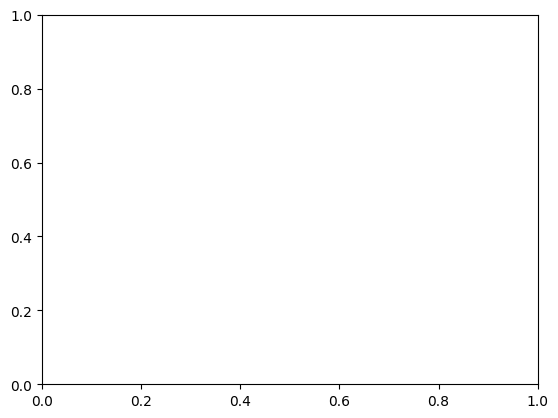

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from ctsm_py.utils import *
import numpy as np
from iv_utils_daint import *

import regionmask 
set_plot_param()

## Load  updated inputdata

In [2]:
import geopandas as gpd

gdf = gpd.read_file('/scratch/snx3000/ivanderk/processing_4p1000/Laikipia.shp')

DriverError: /scratch/snx3000/ivanderk/processing_4p1000/Laikipia.shp: No such file or directory

In [ ]:
# directory settings

inputdir = '/scratch/snx3000/ivanderk/CCLM2_inputdata/cesm_inputdata/CTSM_hcru_inputdata/'

figdir = '/users/ivanderk/notebooks_4p1000/figures/'

filename_ctsm52 = 'surfdata_360x720cru_hist_16pfts_CMIP6_2000_c230915.nc'
filename_clm5 = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
ds_input_ctsm52 = xr.open_dataset(inputdir+filename_ctsm52)


# load scenarios
scenarios = ['medium','high','4p1000']
inputdir_4p1000 = '/scratch/snx3000/ivanderk/processing_4p1000/surfdata_4p1000/'
d_input_scen = {}
for scenario in scenarios: 
    filename_clm5_scenario = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc'
    d_input_scen[scenario] = xr.open_dataset(inputdir_4p1000+filename_clm5_scenario)


In [ ]:
landmask = ds_input_ctsm52['LANDFRAC_PFT']>0

da_orgc    = ds_input_ctsm52['ORGC']
da_bulk    = ds_input_ctsm52['BULK']
da_cfrag   = ds_input_ctsm52['CFRAG']
da_organic = ds_input_ctsm52['ORGANIC']

da_pct_clay    = ds_input_ctsm52['PCT_CLAY']
da_pct_sand    = ds_input_ctsm52['PCT_SAND']

# for analysis
da_pct_crop = ds_input_ctsm52['PCT_CROP']
da_pct_grass = ds_input_ctsm52['PCT_NAT_PFT'].sel(natpft=13) + ds_input_ctsm52['PCT_NAT_PFT'].sel(natpft=14)

da_pct_grass_13 = ds_input_ctsm52['PCT_NAT_PFT'].sel(natpft=13)
da_pct_grass_14 = ds_input_ctsm52['PCT_NAT_PFT'].sel(natpft=14)

### Plotting purpose settings

In [ ]:
# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup'
case = case_ctl
block = "lnd"
stream = "h0"
variables = ["watsat", "H2OSOI" ]
start_year = 2004
end_year = 2004
time_slice = slice(str(start_year) + "-01-01", str(end_year) + "-12-01")
ds = import_case(case_ctl, myVars=variables, timeSlice=time_slice,  alter_lons=False)

In [ ]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()
levsoi_depth = [0] +levsoi_depth
# get info on soil levels
levsoi = ds['levsoi'].values
levgrnd = ds['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

## Plot global grasslands map

In [ ]:
# define scenario
scenario = 'medium'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup2'

vlims = [-2e-2,2e-2]

pft_int = 100

variable = "H2OSOI" 

da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)
da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)
#da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
#da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

#da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
#da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name

da_delta = (da_pft_scen - da_pft_ctl)



In [ ]:
## volumetric soil moisture, aggregating over different layers
levsoi_selections = [ (0,4), (5,9)]
proj=ccrs.PlateCarree()
fig, axes = plt.subplots(2,1,figsize=(10,7), subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()
levels = np.arange(-0.015,0.016,0.001)
labels = ['a.','b.']
for i,levsoi_sel in enumerate(levsoi_selections):
    
    ax = axes[i]
    da_delta_mean = da_delta.isel(levsoi=range(levsoi_sel[0],levsoi_sel[1])).weighted(da_delta.levsoi).mean('levsoi')


    # limiting values for plotting are given    
    da_delta_mean.plot(ax=ax, cmap='BrBG', vmin=vlims[0], vmax=vlims[1], extend='both', levels = levels, cbar_kwargs={'label': 'mm$^3$/mm$^3$', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
    gdf.boundary.plot(ax=ax, color='red')

    ax.set_title('Mean volumetric soil water between '+str(levsoi_depth[levsoi_sel[0]])+' and '+str(levsoi_depth[levsoi_sel[1]+1])+ ' m', loc='right')
    ax.set_title(labels[i], loc='left')

    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent((-180,180,-63,90), crs=proj);  
    ax.axis('off')
    
fig.tight_layout()

## Plot soil moisture and SOC profile at Laikipia

In [ ]:
mask_laikipia

In [ ]:

pft_int = 100
print('processing pft: '+str(pft_int))
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.medium.spunup2'

variable = 'H2OSOI'
# calculate delta and relative delta of saturation ratio. 
da_pft_scen = xr.open_dataset(procdir+'/postprocessing/pft_gridding/'+variable+'_'+str(pft_int)+'.'+case_scen+'.seasmean.nc')[variable+'_'+str(pft_int)]
da_pft_ctl  = xr.open_dataset(procdir+'/postprocessing/pft_gridding/'+variable+'_'+str(pft_int)+'.'+case_ctl +'.seasmean.nc')[variable+'_'+str(pft_int)]

mask_laikipia = regionmask.mask_geopandas(gdf, da_pft_scen.lon.values, da_pft_scen.lat.values)

if 'ivt_str' not in da_pft_scen.coords: 
    da_pft_scen = da_pft_scen.assign_coords({"ivt_str": "weighted sum of c3 and c4 grasses"})

if 'ivt_str' not in da_pft_ctl.coords: 
    da_pft_ctl = da_pft_ctl.assign_coords({"ivt_str": "weighted sum of c3 and c4 grasses"})    

da_delta = da_pft_scen - da_pft_ctl
da_delta_rel = (da_delta/ abs(da_pft_ctl))*100
if variable =='SMP': 

    da_delta = da_delta.isel(levgrnd=slice(0,10)).rename({'levgrnd':'levsoi'}).squeeze()
    da_delta_rel = da_delta_rel.isel(levgrnd=slice(0,10)).rename({'levgrnd':'levsoi'}).squeeze()

da_delta = da_delta.squeeze().where(mask_laikipia.compute(), drop=True)
da_delta_rel = da_delta_rel.squeeze().where(mask_laikipia.compute(), drop=True)

# calculate regional means. 
da_region_seasmean = da_delta.mean(dim=('lat','lon'))

# calculate regional means. 
da_region_rel = da_delta_rel.mean(dim=('lat','lon'))

print()

In [11]:
pft_int = 100
print('processing pft: '+str(pft_int))
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.medium.spunup2'

variable = 'QROOTSINK'
# calculate delta and relative delta of saturation ratio. 
da_ctl_region_qroot_seasmean  = xr.open_dataset(procdir+'/postprocessing/pft_gridding/'+variable+'_'+str(pft_int)+'.'+case_ctl +'.seasmean.nc')[variable+'_'+str(pft_int)].mean(dim=('lat','lon'))

if 'ivt_str' not in da_pft_ctl.coords: 
    da_ctl_region_qroot_seasmean = da_ctl_region_qroot_seasmean.assign_coords({"ivt_str": "weighted sum of c3 and c4 grasses"})    


processing pft: 100


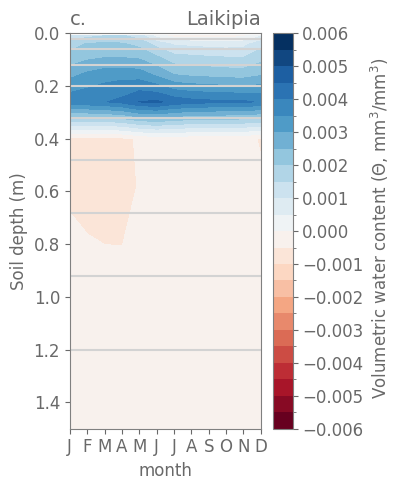

In [14]:
flag_plot_rootuptake = False
figsize = (4,5)
fig, ax = plt.subplots(1,1,figsize=figsize)


levels = np.arange(-0.006,0.0065,0.0005)
ticks  = np.arange(-0.006,0.0065,0.001)

da_region_seasmean.plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' Volumetric water content ($\Theta$, mm$^3$/mm$^3$)', 'ticks':ticks}, levels= levels)
ax.hlines(levsoi_depth, 1,12, color='lightgrey', alpha=1)

# plot QROOT
if flag_plot_rootuptake: 
    levels_qroot = np.arange(0,2.75e-6,0.5e-6)
    cs = da_ctl_region_qroot_seasmean.plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
    ax.clabel(cs, inline=True, fontsize=10)

ax.set_ylim([1.5,0])
ax.set_title('Laikipia', loc='right')
ax.set_title(' ', loc='center')
ax.set_title('c.', loc='left')

ax.set_ylabel('Soil depth (m)')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
fig.tight_layout()

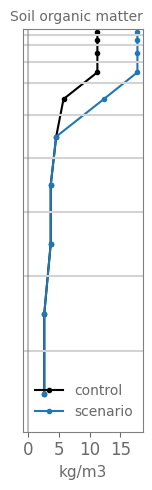

In [20]:
figsize = (1.5,5)

fig, ax = plt.subplots(1,1,figsize=figsize)
input_variables = ['ORGANIC']
scenario='medium'    
inputdir = procdir+'surfdata_4p1000/'
ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_CTL.nc', myVars=input_variables,rename_lsmlatlon=True)
pct_organic = ds_input['ORGANIC'].where(mask_laikipia.compute(), drop=True).mean(dim=('lat','lon'))

ax.plot(pct_organic, levsoi[:len(pct_organic.nlevsoi.values)], marker='.',color = 'k',  label='control')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

scenario='medium'    
inputdir = procdir+'surfdata_4p1000/'
ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

# adapt lons and lats
ds_input['lon'] = ds_lonlat['lon']
ds_input['lat'] = ds_lonlat['lat']

ds_input = lon_pm2idl(ds_input)

pct_organic_scen = ds_input['ORGANIC'].where(mask_laikipia.compute(), drop=True).mean(dim=('lat','lon'))
ax.plot(pct_organic_scen, levsoi[:len(pct_organic.nlevsoi.values)], marker='.', label='scenario')

#ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('kg/m3',fontsize=11)   
for depth in levsoi_depth:
    ax.axhline(depth, color='lightgrey', alpha=1)
    
    
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks([])
ax.set_xticks([0,5,10,15])

ax.set_ylim([1.5,0]); 
ax.legend(frameon=False, fontsize=10)
ax.set_title('Soil organic matter', loc='right', fontsize=10);

fig.tight_layout()